# Linear Regression

In [1]:
%pip install d2l==1.0.3

Note: you may need to restart the kernel to use updated packages.


In [11]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

## Defining the Model

- Initialize weights by drawing random numbers from a normal distribution with mean 0 and a standard deviation of 0.01
- set bias 0

In [18]:
class LinearRegressionScratch(d2l.Module):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        # weight은 학습해서 업데이트해야하는 파라미터니까
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        # bias도 마찬가지!
        self.b = torch.zeros(1, requires_grad=True)

- weight **w**, input features **X**, bias **b**(scalar)

In [20]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    #self: 모델 자체, X: 피쳐니까 행렬곱으로 표현하면
    return torch.matmul(self, X) + self.b


## Defining the Loss Function

- transform true value y into the predicted value's shape y_hat
- averaged loss value를 최종결과로 return

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    #mse정의는 예측값(yhat)과 실제값 y의 차이를 제곱 후 평균이므로,
    l = (y_hat - y) ** 2
    return l.mean()

## Defining the Optimization Algorithm

과제는 아니지만, 전체적인 deep learning pipeline을 파악해주세요!

In [ ]:
class SGD(d2l.HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        # 파라미터와 learning rate 저장하는 코드
        self.save_hyperparameters()

    def step(self):
        # 한 번의 과정 (minibatch? 기준) 업데이트
        for param in self.params:
            # 기울기 반대방향으로 간다
            param -= self.lr * param.grad

    def zero_grad(self):
        # gradient 초기화 (안하면 계속 누적되므로 학습이 안됨)
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    #SGD 최적화 진행
    return SGD([self.w, self.b], self.lr)

##Training

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$


In [25]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    #학습모드 시작
    self.model.train()
    for batch in self.train_dataloader:
        #배치 형태로 학습함, 배치 내에서의 loss 계산
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad(): #역전파시 gradient 초기화해서 학습 (아니면 누적됨!)
            loss.backward()
            if self.gradient_clip_val > 0:  
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None: #validation 없으면 끝내기
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch)) # 학습 하지 않아도 되므로!
        self.val_batch_idx += 1

loss를 확인해봅시다 !

In [26]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

ValueError: optimizer got an empty parameter list

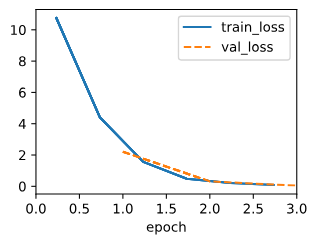

-정답 그림

# Softmax Regression

다양한 X를 설정해서 진행해주셔도 좋을 거 같습니다 :>

In [ ]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True) # 각각 어느 방향으로 더해서 차원을 유지한 열/행벡터로 유지할지

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

softmax를 구현해주세요

In [ ]:
def softmax(X):
    exp_X = torch.exp(X) #지수함수꼴
    part = exp_X.sum(dim=1, keepdims=True) #다 더해줌
    return exp_X/part

In [33]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.3070, 0.1786, 0.2025, 0.1407, 0.1713],
         [0.1294, 0.1594, 0.3374, 0.2159, 0.1578]]),
 tensor([1.0000, 1.0000]))

## Model

- 28*28 pixel image를 가지고, flatten하여 vector로 만듦
- 10 class 존재

In [38]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        #위와 같이, 파라미터를 학습해야하므로 true를 넣어줍니다!
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

In [39]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    # -1은 배치 크기를 알아서 계산하라는 것이라고 합니다 (feat.gpt)
    # 뒤 shpae[0]은 가중치의 입력차원을 일치하도록 함
    X = X.reshape((-1, self.W.shape[0]))
    #행렬곱 형태로 만들어주기
    return softmax(torch.matmul(X, self.W) + self.b)

## Cross-Entropy Loss

다양한 y로 연습해보셔도 좋을 거 같습니다 :>

In [34]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Cross entropy loss를 구현해주세요

In [40]:
def cross_entropy(y_hat, y):
    # 정답 확률만 뽑아내서 로그 취하고 평균내기
    return -torch.log(y_hat[range(len(y_hat)), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [41]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

In [43]:
data = d2l.FashionMNIST(batch_size=256)
# 인풋은 28 * 28 픽셀개수이므로, 아웃풋은 MNIST가 10개의 클래스를 가지므로
model = SoftmaxRegressionScratch(num_inputs= 784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

OSError: [Errno 30] Read-only file system: '../data'

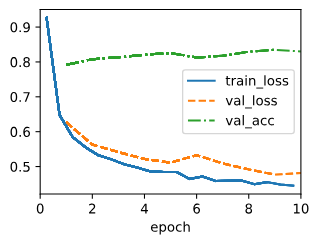
-정답 그림

## Prediction

어떤 방식으로 prediction 및 사진이 나오는지 확인해주세요

In [44]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

TypeError: matmul(): argument 'input' (position 1) must be Tensor, not LinearRegressionScratch

In [16]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

NameError: name 'preds' is not defined